## Great Plains Low-Level Jet events in HighRes

In [1]:
import glob
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [2]:
import cartopy
cartopy.config['pre_existing_data_dir']='/ihesp/shared/cartopy_features'
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#### Mess around with time criteria

#### Open files with results of jet criteria search

In [3]:
#-- Input jet search files
path = '/ihesp/user/asblack/'
filename_1992 = 'jet_highres_hist_6hr_check_199207.nc'
#filename_1992 = 'jet_lowres_fv_hist_6hr_check_199207.nc'
da_1992 = xr.open_dataset(path + filename_1992).llj_flag

In [4]:
#-- Input jet info files
path = '/ihesp/user/asblack/'
filename_1992 = 'HighRes_6hr_jet_maxvals_levels_199207.nc'
#filename_1992 = 'LowRes_6hr_jet_maxvals_levels_199207.nc'

max_values_1992 = xr.open_dataset(path+filename_1992).max_values
max_levels_1992 = xr.open_dataset(path+filename_1992).max_levels

In [5]:
da_1992_sum = da_1992.sum(dim="time")
da_1992_freq = ( da_1992_sum / len(da_1992.time) ) * 100.

In [6]:
#-- Mask maximum jet nose wind speed and level values to only days where there was a LLJ
max_values_masked_1992 = da_1992 * max_values_1992
max_levels_masked_1992 = da_1992 * max_levels_1992
#-- Set zero value to nan
max_values_masked_1992 = max_values_masked_1992.where(max_values_masked_1992!=0, drop=True)
max_levels_masked_1992 = max_levels_masked_1992.where(max_levels_masked_1992!=0, drop=True)

In [7]:
#-- Spatial mean jet properties
max_values_spatial_mean_1992 = max_values_masked_1992.mean(dim="lat").mean(dim="lon")
max_levels_spatial_mean_1992 = max_levels_masked_1992.mean(dim="lat").mean(dim="lon")

In [8]:
#-- Messing with phase plot
max_values_spatial_mean_1992.groupby("time.hour")

DataArrayGroupBy, grouped over 'hour'
4 groups with labels 0, 6, 12, 18.

In [9]:
llj_events_1992 = max_values_spatial_mean_1992

In [10]:
llj_events_1992.groupby("time.hour").count()

<xarray.DataArray (hour: 4)>
array([27, 31, 31, 31])
Coordinates:
  * hour     (hour) int64 0 6 12 18

In [ ]:
#-- For files to write out IVT
path = '/ihesp/user/asblack/regridded/'
filenames = 'cam_h3_HR*'
ds = xr.open_mfdataset(path+filenames,
                   engine='netcdf4',
                   parallel=True,
                   concat_dim='time',
                   data_vars='minimal',
                   coords='minimal',
                   compat='override').isel(time=slice(67,191))

global_offset = 360
ds_u = ds.U.sel(lat=slice(25,45),
                lon=slice(global_offset-100,global_offset-80))
ds_v = ds.V.sel(lat=slice(25,45),
                lon=slice(global_offset-100,global_offset-80))
ds_q = ds.Q.sel(lat=slice(25,45),
                lon=slice(global_offset-100,global_offset-80))


ds_u.reindex(lev=ds_u.lev[::-1])
ds_v.reindex(lev=ds_v.lev[::-1])
ds_q.reindex(lev=ds_q.lev[::-1])

ds_u.load()
ds_v.load()
ds_q.load()

In [ ]:
#-- Compute moisture flux
qu = ds_u * ds_q
qv = ds_v * ds_q

In [ ]:
#-- Integrate moisture flux over vertical levels (must run notebook function 'integrate')
qu_int = integrate(qu, over_dim="lev", x=(qu["lev"] * 100) / 9.81)
qv_int = integrate(qv, over_dim="lev", x=(qv["lev"] * 100) / 9.81)

In [ ]:
#-- Compute IVT magnitude
IVT = np.sqrt(np.square(qu_int) + np.square(qv_int))

In [ ]:
#-- Write to output file
IVT = xr.Dataset(
            data_vars=dict(
                IVT=(["time", "lat", "lon"], IVT.data)
            ),
            coords=dict(
                time=(["time"], IVT.time.data),
                lat=(["lat"], IVT.lat.data),
                lon=(["lon"], IVT.lon.data)
            ),
            attrs=dict(description="LowRes 0.75x0.75 6-hourly IVT")
)

path = '/ihesp/user/asblack/'
filename = 'IVT_lowres_6hr_199207.nc'
IVT.to_netcdf(path + filename)

In [ ]:
#-- For files to write out single level values
path = r'/net/gda.geos.tamu.edu/gda1/era5/0.75x0.75/single/netcdf/1-hourly/1991/199107/'
filenames = glob.glob(path + "*.ncd")
filenames.sort()

In [ ]:
global_offset = 360
ds = xr.open_mfdataset(filenames,
                   engine='netcdf4',
                   parallel=True,
                   concat_dim='time',
                   data_vars='minimal',
                   coords='minimal',
                   compat='override').mcpr.sel(latitude=slice(45,25),
                                          longitude=slice(global_offset-100,global_offset-80))

ds.load()

#-- Resample to 6-hourly mean
ds_6h = ds.resample(time="6H").mean()

In [ ]:
ds_6h = ds_6h.rename({'latitude': 'lat','longitude': 'lon'})

In [ ]:
#-- Write to output file
var = xr.Dataset(
            data_vars=dict(
                mcpr=(["time", "lat", "lon"], ds_6h.data)
            ),
            coords=dict(
                time=(["time"], ds_6h.time.data),
                lat=(["lat"], ds_6h.lat.data),
                lon=(["lon"], ds_6h.lon.data)
            ),
            attrs=dict(description="ERA5 0.75x0.75 resampled 6-hourly mcpr")
)

path = '/net/snowflake.ad.geos.tamu.edu/stor/homes/asblack/ERA5_work/'
filename = 'ERA5_lowres_6hr_mcpr_199107.nc'
var.to_netcdf(path + filename)

In [ ]:
path = '/net/snowflake.ad.geos.tamu.edu/stor/homes/asblack/ERA5_work/'
filename = 'ERA5_lowres_6hr_tp_199107.nc'
tp = xr.open_dataset(path+filename).tp

### Plot - composite

In [11]:
path = '/ihesp/user/asblack/'
filename = 'IVT_highres_6hr_199207.nc'
IVT = xr.open_dataset(path + filename).IVT

In [12]:
mask = da_1992
IVT_masked = IVT * mask

In [13]:
#-- Set zero value to nan
IVT_masked = IVT_masked.where(IVT_masked!=0, drop=True)

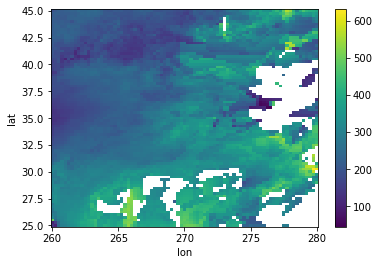

In [14]:
IVT_masked.mean(dim="time").plot()

In [ ]:
#-- Set figure plot bounds
fig = plt.figure(figsize=(12, 10))

gsFig = plt.GridSpec(1, 1)
gsFig.update(left=0.10, right=0.90, bottom = 0.12, top = 0.92)
axFig_1 = plt.subplot(gsFig[0, 0], projection=ccrs.PlateCarree(180))

gsCB = plt.GridSpec(1, 1)
gsCB.update(left=0.14, right=0.86, bottom = 0.06, top = 0.08)
axCB = plt.subplot(gsCB[0, 0])

#-- Xarray plot

image = IVT_masked.mean(dim="time").plot(ax=axFig_1,
                               add_colorbar=False,
                               vmin=0,
                               vmax=700,
                               transform=ccrs.PlateCarree())

#-- Add coastlines
axFig_1.add_feature(cfeature.COASTLINE, edgecolor='black',linewidth=1, zorder=1)

#-- Modify gridlines
gl = axFig_1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False ; gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER ; gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-100, -95, -90, -85, -80])
gl.ylocator = mticker.FixedLocator([25, 30, 35, 40, 45])
gl.xlabel_style = {'size': 20} ; gl.ylabel_style = {'size': 20}

#-- Fix colorbar
cb = plt.colorbar(image, cax=axCB, orientation='horizontal', extend="max")
cb.set_label(label='kg/m/s', size=18)
cb.ax.tick_params(labelsize=16)

#-- Labels
axFig_1.set_title("IVT composite - HR | July 1992", fontsize=24, pad=20)

#-- Save image
plt.savefig('/ihesp/user/asblack/llj_HR_IVT_composite_July_1992.png')

### Plot - cases

In [ ]:
wind_speed = np.sqrt( np.square(ds_u.sel(time='1992-07-11T18')) 
                    + np.square(ds_v.sel(time='1992-07-11T18')) )

pp = wind_speed.sel(lev=925, method='nearest')
pp = pp.sel(lat=slice(20,60), lon=slice(360-125,360-70))

fig = plt.figure(figsize=(12, 10))

gsFig = plt.GridSpec(1, 1)
gsFig.update(left=0.05, right=0.95, bottom = 0.09, top = 0.65)
axFig_1 = plt.subplot(gsFig[0, 0], projection=ccrs.PlateCarree(180))

gsCB = plt.GridSpec(1, 1)
gsCB.update(left=0.20, right=0.80, bottom = 0.04, top = 0.06)
axCB = plt.subplot(gsCB[0, 0])

#-- Xarray plot
image = pp.plot(ax=axFig_1,
                add_colorbar=False,
                vmin=0,
                vmax=20,
                transform=ccrs.PlateCarree())

#-- Add coastlines
axFig_1.add_feature(cfeature.COASTLINE, edgecolor='black',linewidth=1, zorder=1)

#-- Modify gridlines
gl = axFig_1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False ; gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER ; gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12} ; gl.ylabel_style = {'size': 12}

#--Fix colorbar
plt.colorbar(image, cax=axCB, orientation='horizontal', extend="max", label='m/s')

#--Labels
axFig_1.set_title("18 UTC 11 July 1992 - 925 hPa wind speed", fontsize=20)

#--save image
plt.savefig('/ihesp/user/asblack/llj_case_199207_18_LR.png')

In [ ]:
ii = IVT.sel(time='1992-07-11T00')

#-- Set figure plot bounds
fig = plt.figure(figsize=(12, 10))

gsFig = plt.GridSpec(1, 1)
gsFig.update(left=0.10, right=0.90, bottom = 0.12, top = 0.92)
axFig_1 = plt.subplot(gsFig[0, 0], projection=ccrs.PlateCarree(180))

gsCB = plt.GridSpec(1, 1)
gsCB.update(left=0.14, right=0.86, bottom = 0.06, top = 0.08)
axCB = plt.subplot(gsCB[0, 0])

#-- Xarray plot

image = ii.plot(ax=axFig_1,
                               add_colorbar=False,
                               vmin=0,
                               vmax=700,
                               transform=ccrs.PlateCarree())

#-- Add coastlines
axFig_1.add_feature(cfeature.COASTLINE, edgecolor='black',linewidth=1, zorder=1)

#-- Modify gridlines
gl = axFig_1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False ; gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER ; gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12} ; gl.ylabel_style = {'size': 12}

#--Fix colorbar
cb = plt.colorbar(image, cax=axCB, orientation='horizontal', extend="max")
cb.set_label(label='kg/m/s', size=18)
cb.ax.tick_params(labelsize=16)

#--Labels
axFig_1.set_title("00 UTC 11 July 1992 - IVT", fontsize=24, pad=20)

#--save image
plt.savefig('/ihesp/user/asblack/llj_IVT_199207_00_HR.png')

In [ ]:
#-- Check event
check = wind_speed.sel(latitude=31, longitude=360-91)

fig, ax = plt.subplots(figsize=(10, 6))

# Define x and y axes
ax.plot(check.values, 
        check.isobaricInhPa)

ax.invert_yaxis()

plt.xlabel('m/s', fontsize=16)
plt.ylabel('hPa', fontsize=16)

#--Labels
ax.set_title('Wind Speed - vertical cross section', fontsize=18)
#--save image
plt.savefig('/h/asblack/ERA5_work/Figures/llj_case_19920826_nose.png')

### Plot - time series

In [ ]:
#-- Set figure plot bounds
fig = plt.figure(figsize=(12, 10))

gsFig = plt.GridSpec(2, 2)
gsFig.update(left=0.05, right=0.95, bottom = 0.10, top = 0.90, hspace=0.4)
axFig_1 = plt.subplot(gsFig[0, 0])
axFig_2 = plt.subplot(gsFig[0, 1])

bins = [10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40]

#-- Xarray plot
max_values_spatial_mean_1992.plot(ax=axFig_1)
max_levels_spatial_mean_1992.plot(ax=axFig_2)

#-- y-axis range
axFig_1.set_ylim([12, 36])
axFig_2.invert_yaxis()

#-- Labels
axFig_1.set_title("Spatial mean LLJ max magnitude - July 1992", fontsize=14)
axFig_2.set_title("Spatial mean LLJ max level - July 1992", fontsize=14)

#-- Save image
plt.savefig('/ihesp/user/asblack/llj_timeseries_199207.png')

### Plot - histogram

In [ ]:
#-- Set figure plot bounds
fig = plt.figure(figsize=(12, 10))

gsFig_top = plt.GridSpec(1, 1)
gsFig_top.update(left=0.37, right=0.63, bottom = 0.68, top = 0.95)
axFig_top = plt.subplot(gsFig_top[0, 0])

gsFig = plt.GridSpec(2, 3)
gsFig.update(left=0.05, right=0.95, bottom = 0.03, top = 0.63)
axFig_1 = plt.subplot(gsFig[0, 0])
axFig_2 = plt.subplot(gsFig[0, 1])
axFig_3 = plt.subplot(gsFig[0, 2])
axFig_4 = plt.subplot(gsFig[1, 0])
axFig_5 = plt.subplot(gsFig[1, 1])
axFig_6 = plt.subplot(gsFig[1, 2])

bins = [10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40]

#-- Xarray plot
image = max_values_masked.plot.hist(ax=axFig_top, bins=bins)

max_values_masked.sel(time='1992-04').plot.hist(ax=axFig_1, bins=bins)

max_values_masked.sel(time='1992-05').plot.hist(ax=axFig_2, bins=bins)

max_values_masked.sel(time='1992-06').plot.hist(ax=axFig_3, bins=bins)

max_values_masked.sel(time='1992-07').plot.hist(ax=axFig_4, bins=bins)

max_values_masked.sel(time='1992-08').plot.hist(ax=axFig_5, bins=bins)

max_values_masked.sel(time='1992-09').plot.hist(ax=axFig_6, bins=bins)

#-- y-axis range
axFig_top.set_ylim([0, 12200])
axFig_1.set_ylim([0, 3200])
axFig_2.set_ylim([0, 3200])
axFig_3.set_ylim([0, 3200])
axFig_4.set_ylim([0, 3200])
axFig_5.set_ylim([0, 3200])
axFig_6.set_ylim([0, 3200])

#-- Labels
axFig_top.set_title("")
axFig_1.set_title("April")
axFig_2.set_title("May")
axFig_3.set_title("June")
axFig_4.set_title("July")
axFig_5.set_title("August")
axFig_6.set_title("September")
plt.suptitle('Magnitude of LLJ maximum | Apr-Sep 1992',fontsize=18)

#-- Save image
plt.savefig('/h/asblack/ERA5_work/Figures/llj_max_values_1992.png')

In [ ]:
#-- Set figure plot bounds
fig = plt.figure(figsize=(12, 10))

gsFig_top = plt.GridSpec(1, 1)
gsFig_top.update(left=0.37, right=0.63, bottom = 0.68, top = 0.95)
axFig_top = plt.subplot(gsFig_top[0, 0])

gsFig = plt.GridSpec(2, 3)
gsFig.update(left=0.05, right=0.95, bottom = 0.03, top = 0.63)
axFig_1 = plt.subplot(gsFig[0, 0])
axFig_2 = plt.subplot(gsFig[0, 1])
axFig_3 = plt.subplot(gsFig[0, 2])
axFig_4 = plt.subplot(gsFig[1, 0])
axFig_5 = plt.subplot(gsFig[1, 1])
axFig_6 = plt.subplot(gsFig[1, 2])

bins = [700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]

#-- Xarray plot
image = max_levels_masked.plot.hist(ax=axFig_top, bins=bins)

max_levels_masked.sel(time='1992-04').plot.hist(ax=axFig_1, bins=bins)

max_levels_masked.sel(time='1992-05').plot.hist(ax=axFig_2, bins=bins)

max_levels_masked.sel(time='1992-06').plot.hist(ax=axFig_3, bins=bins)

max_levels_masked.sel(time='1992-07').plot.hist(ax=axFig_4, bins=bins)

max_levels_masked.sel(time='1992-08').plot.hist(ax=axFig_5, bins=bins)

max_levels_masked.sel(time='1992-09').plot.hist(ax=axFig_6, bins=bins)

#-- y-axis range
axFig_top.set_ylim([0, 8200])
axFig_1.set_ylim([0, 2200])
axFig_2.set_ylim([0, 2200])
axFig_3.set_ylim([0, 2200])
axFig_4.set_ylim([0, 2200])
axFig_5.set_ylim([0, 2200])
axFig_6.set_ylim([0, 2200])

#-- Labels
axFig_top.set_title("")
axFig_1.set_title("April")
axFig_2.set_title("May")
axFig_3.set_title("June")
axFig_4.set_title("July")
axFig_5.set_title("August")
axFig_6.set_title("September")
plt.suptitle('Level of LLJ maximum | Apr-Sep 1992',fontsize=18)

#-- Save image
plt.savefig('/h/asblack/ERA5_work/Figures/llj_max_levels_1992.png')

### Plot - frequency

In [ ]:
my_cmap = create_colormap('/ihesp/user/asblack/rainbow.rgb')

In [ ]:
#-- Set figure plot bounds
fig = plt.figure(figsize=(12, 10))

gsFig = plt.GridSpec(1, 1)
gsFig.update(left=0.10, right=0.90, bottom = 0.12, top = 0.92)
axFig_1 = plt.subplot(gsFig[0, 0], projection=ccrs.PlateCarree(180))

gsCB = plt.GridSpec(1, 1)
gsCB.update(left=0.14, right=0.86, bottom = 0.06, top = 0.08)
axCB = plt.subplot(gsCB[0, 0])

#-- Xarray plot
image = da_1992_freq.plot(ax=axFig_1,
                               add_colorbar=False,
                               vmin=0,
                               vmax=40,
                               cmap = my_cmap, 
                               transform=ccrs.PlateCarree())

#-- Add coastlines
axFig_1.add_feature(cfeature.COASTLINE, edgecolor='black',linewidth=1, zorder=1)

#-- Modify gridlines
gl = axFig_1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False ; gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER ; gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-100, -95, -90, -85, -80])
gl.ylocator = mticker.FixedLocator([25, 30, 35, 40, 45])
gl.xlabel_style = {'size': 20} ; gl.ylabel_style = {'size': 20}

#--Fix colorbar
cb = plt.colorbar(image, cax=axCB, orientation='horizontal', extend="max")
cb.set_label(label='%', size=18)
cb.ax.tick_params(labelsize=16)

#--Labels
axFig_1.set_title("GPLLJ Frequency - LR | July 1992", fontsize=24, pad=20)

#--save image
plt.savefig('/ihesp/user/asblack/llj_LR_frequency_199207.png')

## Notebook functions

In [ ]:
def create_colormap(filename):
    """ 
        Returns a ListedColormap from input rgb file
            
        | Author: Amanda Black
        | Date: 09/11/2021
            
        Parameters
        ----------
        filename : string
            Name of file containing rgb values
    
        Returns
        -------
        newcmp : new ListedColormap
    """
    
    from matplotlib.colors import ListedColormap
    
    f = open(filename, 'r')

    #-- Read input file, skipping first 2 rows
    list2D = []
    for line in f.readlines()[2:]:
            list2D.append(line.split('\t'))
            
    #-- Strip \n from end of every list within the list
    final_big_list = []
    for first in list2D:
        final_list = []
        for second in first:
            final_list.append(second.strip())
        final_big_list.append(final_list)

    #-- Convert list to array
    array2D = np.array(final_big_list)
    
    #-- Drop first column
    array2D = array2D[:,1:4]
    
    #-- Convert to a float/255.0 value (makes it a list again)
    array2D = [[float(num)/255.0 for num in lstt[:]] for lstt in array2D]
    
    #-- Convert back to array
    array2D = np.array(array2D)
    
    newcmp = ListedColormap(array2D)
    
    #-- Check new colormap
    # create mock data
    #data = np.random.random([100, 100]) * 10

    # show figure
    #plt.figure(figsize=(7, 6))
    #plt.pcolormesh(data, cmap = my_cmap)
    #plt.colorbar()

    return newcmp

In [ ]:
def integrate(da, over_dim, x=None, dx=None, method='trapz', cumulative=False, skipna=False):
    """ 
        Returns trapezoidal/rectangular integration along specified dimension 
        
        | Author: Dougie Squire
        | Date: 16/08/2018
        
        Parameters
        ----------
        da : xarray DataArray
            Array containing values to integrate
        over_dim : str
            Dimension to integrate
        x : xarray DataArray, optional
            Values to use for integrand. Must contain dimensions over_dim. If None, x is determined\
                    from the coords associated with over_dim
        dx : value, optional
            Integrand spacing used to compute the integral. If None, dx is determined from x
        method : str, optional
            Method of performing integral. Options are 'trapz' for trapezoidal integration, or 'rect'\
                    for rectangular integration
        cumulative : bool, optional
            If True, return the cumulative integral    
            
        Returns
        -------
        integral : xarray DataArray
            Array containing the integral along the specified dimension
            
        Examples
        --------
        >>> A = xr.DataArray(np.random.normal(size=(3,2)), coords=[('x', np.arange(3)), 
        ...                                                        ('y', np.arange(2))])
        >>> doppyo.utils.integrate(A, over_dim='x')
        <xarray.DataArray 'integral' (y: 2)>
        array([-0.20331 , -0.781251])
        Coordinates:
          * y        (y) int64 0 1
        See Also
        --------
        numpy.trapz
    """

    if x is None:
        x = da[over_dim]
    
    if len(x) == 1:
        if dx is None:
            raise ValueError('Must provide dx for integration along dimension with length 1')
        integral = (da * dx).drop(over_dim).squeeze()
    elif method == 'trapz':
        if dx is None:
            dx = x - x.shift(**{over_dim:1})
            dx = dx.fillna(0.0)

        if cumulative:
            integral = ((da.shift(**{over_dim:1}) + da) * dx / 2.0) \
                       .fillna(0.0) \
                       .cumsum(over_dim, skipna=skipna) 
        else:
            integral = ((da.shift(**{over_dim:1}) + da) * dx / 2.0) \
                       .fillna(0.0) \
                       .sum(over_dim, skipna=skipna) 
    elif method == 'rect':
        if dx is None:
            dx1 = x - x.shift(**{over_dim:1})
            dx2 = -(x - x.shift(**{over_dim:-1}))
            dx = dx1.combine_first(dx2)

        if cumulative:
            integral = (da * dx).cumsum(over_dim, skipna=skipna) 
        else:
            integral = (da * dx).sum(over_dim, skipna=skipna) 
    else:
        raise ValueError(f'{method} is not a recognised integration method')
    
    return integral